### Loading all necessary modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score, roc_curve, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier

## Load datasets train, test

In [2]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_train.name = "training dataset"
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
df_test.name = "test dataset"

In [3]:
print(f"No of rows in training dataset - {df_train.shape[0]}")
print(f"No of rows in test dataset - {df_test.shape[0]}")
print(f"No of columns in training dataset - {df_train.shape[1]}")
print(f"No of columns in test dataset - {df_test.shape[1]}")

No of rows in training dataset - 891
No of rows in test dataset - 418
No of columns in training dataset - 12
No of columns in test dataset - 11


### Description of columns 

**pclass**: Passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)

**survival**: A Boolean indicating whether the passenger survived or not (0 = No; 1 = Yes); this is our target

**name**: A field rich in information as it contains title and family names

**sex**: male/female

**age**: Age, asignificant portion of values aremissing

**sibsp**: Number of siblings/spouses aboard(Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic Husband or Wife of Passenger Aboard Titanic)

**parch**: Number of parents/children aboard (Mother or Father of Passenger Aboard Titanic Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic)

**ticket**: Ticket number.

**fare**: Passenger fare (British Pound).

**cabin**: Doesthe location of the cabin influence chances of survival?

**embarked**: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Checking for Missing values

In [4]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n') 

In [5]:
for df in [df_train, df_test]:
    print('{}'.format(df.name))
    print('-----------------------------')
    display_missing(df)

training dataset
-----------------------------
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


test dataset
-----------------------------
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




### Following columns value missing in train data

**Age** - 177

**Cabin** - 687

**Embarked** - 2


### Following columns value missing in train data
**Age** - 86

**Fare** - 1

**Cabin** - 327


## Satrt Filling Missing Values

## Age

We may use train and test **Age** medain separately to fill Age's missing value. But First need to check Age's correlation with other features.

In [6]:
df_corr = df_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr[df_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
5,Age,Age,1.000000
12,Age,Pclass,0.369226
16,Age,SibSp,0.308247
21,Age,Parch,0.189119
26,Age,Fare,0.096067
31,Age,Survived,0.077221
36,Age,PassengerId,0.036847


As we can see Age have correlation with Pclass dn SibSp. So we fill Age's value groupb by Pclass, SibSp and then take median. 

In [7]:
df_train['Age'] = df_train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
df_test['Age'] = df_test.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

## Embarked 

Embarked is a categorical variable. so we can simply take mode and fill na.

In [8]:
df_train['Embarked'].fillna(df_train['Embarked'].mode(dropna=True)[0], inplace=True)
df_test['Embarked'].fillna(df_train['Embarked'].mode(dropna=True)[0], inplace=True)

## Fare

In [9]:
med_fare = df_test.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_test['Fare'] = df_test['Fare'].fillna(med_fare)

# Visualization 

## Distribution of Target(Survived) variable

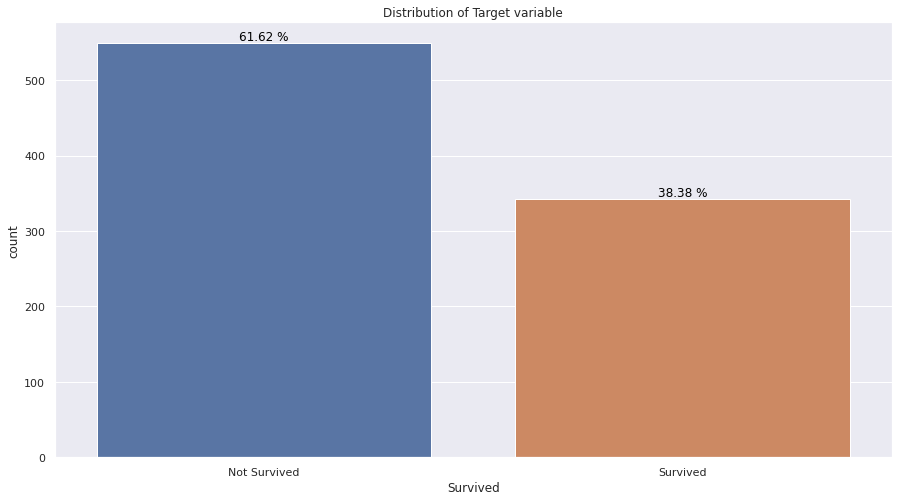

In [10]:
df_gb_survived = df_train.groupby('Survived')['Name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False)
df_gb_survived['count_per'] = round(df_gb_survived['count']/len(df_train)*100, 2)

df_gb_survived['Survived'] = df_gb_survived['Survived'].apply(lambda x: 'Not Survived' if x == 0 else 'Survived')

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Survived', y='count', data=df_gb_survived)

for i in ax.patches:
    vl = round((i.get_height()/len(df_train))*100,2)
    ax.annotate('{} %'.format(vl), (i.get_x()+0.4, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.title("Distribution of Target variable")
plt.show()

### As tyou can see only 38.38% passengers were able to Survived

## Distribution of target variable by Sex 

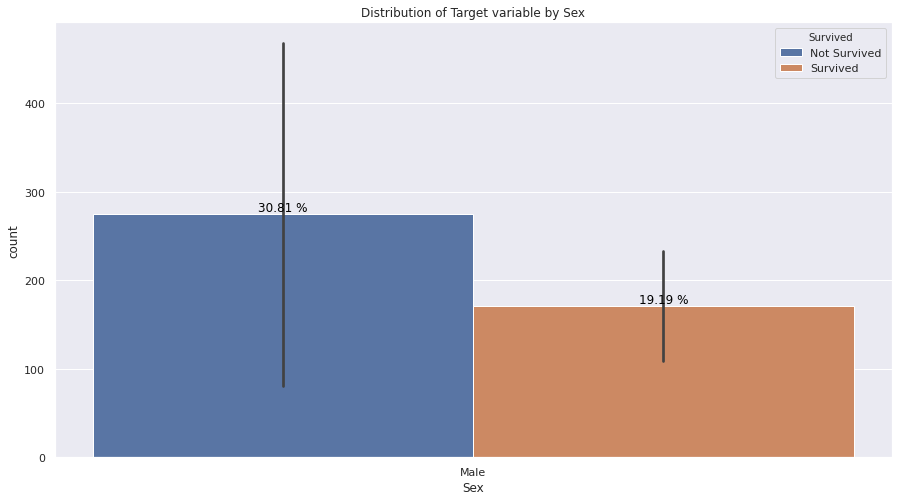

In [11]:
df_gb_sex_survived = df_train.groupby(['Survived','Sex'])['Name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False)
df_gb_sex_survived['Survived'] = df_gb_sex_survived['Survived'].apply(lambda x: 'Not Survived' if x == 0 else 'Survived')
df_gb_sex_survived['Sex'] = df_gb_sex_survived['Sex'].apply(lambda x: 'Female' if x == 0 else 'Male')
#df_gb_sex_survived

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Sex', y='count', hue='Survived', data=df_gb_sex_survived)

for i in ax.patches:
    vl = round((i.get_height()/len(df_train))*100,2)
    ax.annotate('{} %'.format(vl), (i.get_x()+0.2, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.title("Distribution of Target variable by Sex")
plt.show()

In [12]:
df_train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


## Distribution of Target variable by Pclass

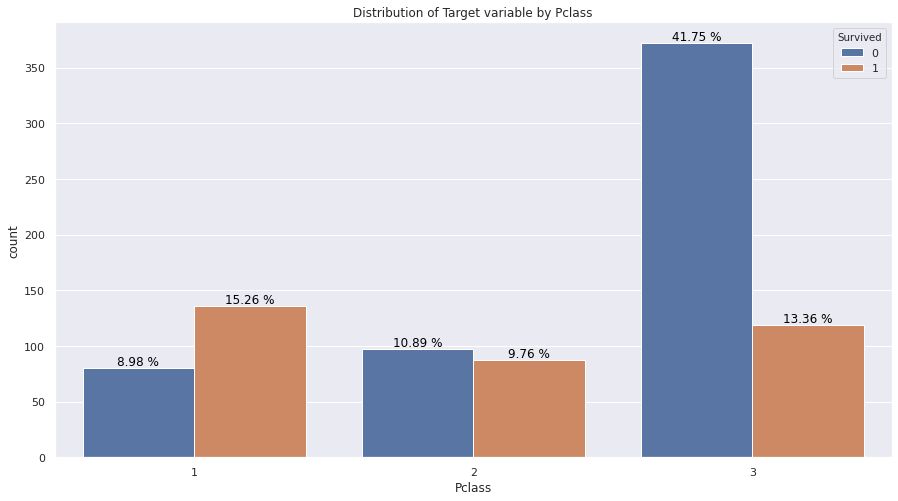

In [13]:
df_gb_pclass_survived = df_train.groupby(['Survived','Pclass'])['Name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False)
df_gb_pclass_survived

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Pclass', y='count', hue='Survived', data=df_gb_pclass_survived)

for i in ax.patches:
    vl = round((i.get_height()/len(df_train))*100,2)
    ax.annotate('{} %'.format(vl), (i.get_x()+0.2, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.title("Distribution of Target variable by Pclass")
plt.show()

# Distribution of Target variable by SibSp

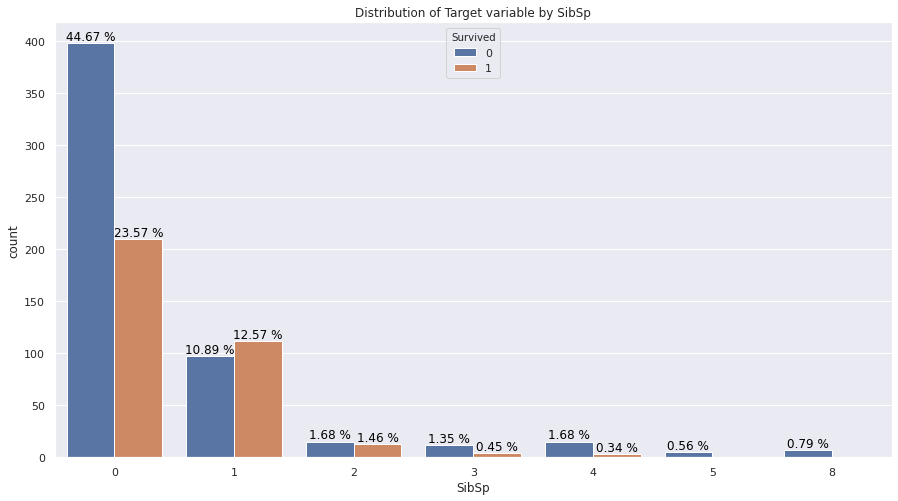

In [14]:
df_gb_sibsp_survived = df_train.groupby(['Survived','SibSp'])['Name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False)
df_gb_sibsp_survived

plt.figure(figsize=(15,8))
ax = sns.barplot(x='SibSp', y='count', hue='Survived', data=df_gb_sibsp_survived)

for i in ax.patches:
    vl = round((i.get_height()/len(df_train))*100,2)
    ax.annotate('{} %'.format(vl), (i.get_x()+0.2, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.title("Distribution of Target variable by SibSp")
plt.show()

# Distribution of Target variable by Parch

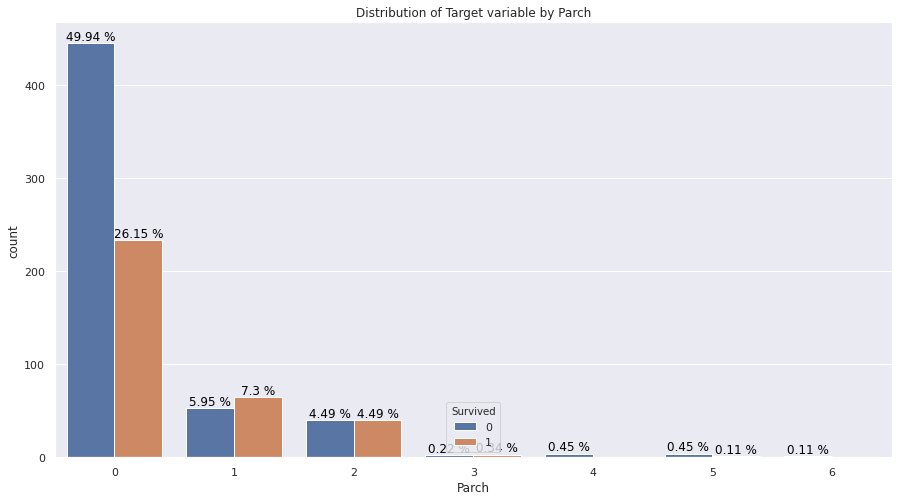

In [15]:
df_gb_parch_survived = df_train.groupby(['Survived','Parch'])['Name'].agg({'count'}).reset_index().sort_values(by='count', ascending=False)
df_gb_parch_survived

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Parch', y='count', hue='Survived', data=df_gb_parch_survived)

for i in ax.patches:
    vl = round((i.get_height()/len(df_train))*100,2)
    ax.annotate('{} %'.format(vl), (i.get_x()+0.2, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.title("Distribution of Target variable by Parch")
plt.show()

### Create Some new features 

We can create a new feature using Parch and SibSp 

In [16]:
df_train['Family_Size'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family_Size'] = df_test['SibSp'] + df_test['Parch'] + 1

### Change Family Size into Small, Medium and Large family group 

In [17]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}

df_train['Family_Size_Grouped'] = df_train['Family_Size'].map(family_map)
df_test['Family_Size_Grouped'] = df_test['Family_Size'].map(family_map)

In [18]:
# creating new variable Is_Married and Title
for ds in [df_train, df_test]:
    ds['Title'] = ds['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    ds['Is_Married'] = 0
    ds['Is_Married'].loc[ds['Title'] == 'Mrs'] = 1

In [19]:
for ds in [df_train, df_test]:
    ds['Title'] = ds['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
    ds['Title'] = ds['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

## Encode Non-numeric variables 

In [20]:
non_numeric_features = ['Embarked', 'Sex', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in [df_train, df_test]:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [21]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for feature in df_train.columns:
    if feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df_train[feature].values.reshape(-1, 1)).toarray()
        n = df_train[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df_train.index
        encoded_features.append(encoded_df)        

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)

encoded_features = []
for feature in df_test.columns:
    if feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df_test[feature].values.reshape(-1, 1)).toarray()
        n = df_test[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df_test.index
        encoded_features.append(encoded_df)        

df_test = pd.concat([df_test, *encoded_features[:6]], axis=1)

In [22]:
drop_cols1 = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Cabin', 'Title', 'Ticket']
drop_cols2 = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'Cabin', 'Title', 'Ticket']

## Scale data 

In [23]:
X = StandardScaler().fit_transform(df_train.drop(columns=drop_cols1))
y = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols2))

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Run Multiple model and check accuracy 

In [25]:
mlist = []
mlist.append(('LogisticRegression', LogisticRegression()))
mlist.append(('Perceptron', Perceptron()))
mlist.append(('SGDClassifier', SGDClassifier()))
mlist.append(('SVC', SVC()))
mlist.append(('LinearSVC', LinearSVC()))
mlist.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
mlist.append(('ExtraTreeClassifier', ExtraTreeClassifier()))
mlist.append(('RandomForestClassifier', RandomForestClassifier()))
mlist.append(('KNeighborsClassifier', KNeighborsClassifier()))
mlist.append(('GaussianNB', GaussianNB()))
mlist.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier())))
mlist.append(('Xgboost', XGBClassifier()))

df = pd.DataFrame(columns=['name', 'score'])
for name, m in mlist:
    m.fit(X_train, y_train)
    score = m.score(X_val, y_val)
    pred = m.predict(X_val)
    err = mean_squared_error(y_val, pred)
    df1 = pd.DataFrame(data={'name': [name], 'score': [score], 'error': [err]})
    df = pd.concat([df, df1])
    
    
df_models = df.reset_index().sort_values(by='score', ascending=False).reset_index().drop(columns=['index', 'level_0'])

In [26]:
df_models

,name,score,error
0,AdaBoostClassifier,0.849162,0.150838
1,Xgboost,0.832402,0.167598
2,LinearSVC,0.821229,0.178771
3,RandomForestClassifier,0.815642,0.184358
4,LogisticRegression,0.810056,0.189944
5,KNeighborsClassifier,0.810056,0.189944
6,SVC,0.804469,0.195531
7,DecisionTreeClassifier,0.804469,0.195531
8,ExtraTreeClassifier,0.804469,0.195531
9,GaussianNB,0.793296,0.206704


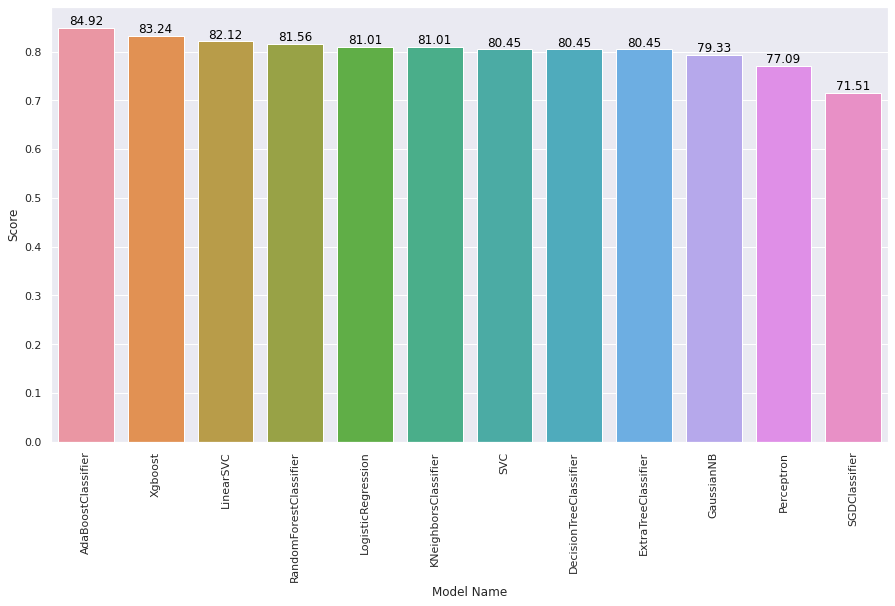

In [27]:
plt.figure(figsize=(15,8))

ax = sns.barplot(x='name', y='score', data=df_models)

for i in ax.patches:
    ax.annotate('{}'.format(round(i.get_height()*100,2)), (i.get_x()+0.4, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.xticks(rotation='90')
plt.xlabel("Model Name")
plt.ylabel('Score')
plt.show()

As you can clearly see **AdaBoostClassifier** and **Xgboost** are showing highest score. We can further enhace the model using GridSearch[](http://)

In [28]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   51.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:  5.8min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [29]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [30]:
xgb1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1,  monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
xgb1.fit(X_train, y_train)

print(xgb1.score(X_train, y_train), xgb1.score(X_val, y_val))

0.8876404494382022 0.8212290502793296


## Classification Report for Validation 

In [31]:
ypred = xgb1.predict(X_val)
print(classification_report(y_val, ypred))
print(confusion_matrix(y_val, ypred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86       105
           1       0.84      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179

[[95 10]
 [22 52]]


## Classification Report for Train

In [32]:
ypred = xgb1.predict(X_train)
print(classification_report(y_train, ypred))
print(confusion_matrix(y_train, ypred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       444
           1       0.92      0.77      0.84       268

    accuracy                           0.89       712
   macro avg       0.90      0.86      0.88       712
weighted avg       0.89      0.89      0.89       712

[[425  19]
 [ 61 207]]


In [33]:
def generate_submission(model):
    result = model.predict(X_test)

    submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
    submission_df['PassengerId'] = df_test['PassengerId']
    submission_df['Survived'] = result
    submission_df.to_csv('submissions_rsb_updated.csv', header=True, index=False)
    submission_df.head(10)

In [34]:
generate_submission(xgb1)